# Modèles Transformer — Comparaison PatchTST, TimeXer, iTransformer, VanillaTransformer

## Objectif
Comparer 4 architectures Transformer modernes pour la prédiction autorégressiive de `Total_reservations`.

## Modèles implémentés

| Modèle | Papier | Idée clé |
|--------|--------|----------|
| **VanillaTransformer** | Vaswani 2017 | Token = pas de temps multivarié |
| **PatchTST** | Nie et al. ICLR 2023 | Token = *patch* (sous-séquence) de la série |
| **TimeXer** | Chen et al. NeurIPS 2024 | PatchTST + Cross-Attention sur les variables exogènes |
| **iTransformer** | Liu et al. ICLR 2024 | Token = *variable* entière (Transformer inversé) |

## Stratégie endogène / exogène
- **Série endogène** : `Total_reservations` — la variable à prédire
- **Features exogènes** : toutes les autres colonnes (météo, jours fériés, jours de semaine…)
  — supposées connues à l'avance (calendaire + prévision météo)

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |
| `D_MODEL` | 64 | Dimension interne des Transformers |
| `N_HEADS` | 4 | Têtes d'attention |
| `N_LAYERS` | 2 | Couches d'encodeur |

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [1]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH  = '../data/df_venues_final.csv'
TARGET_COL = 'GLOBAL'               # série endogène

WINDOW      = 5      # jours de contexte
N_TEST      = 5      # jours de test
N_VAL       = 20     # jours de validation (~4 semaines)
PATCH_SIZE  = 1      # taille d'un patch (WINDOW doit être divisible par PATCH_SIZE)

# Entraînement
EPOCHS      = 200
LR          = 3e-4
BATCH_SIZE  = 16
PATIENCE    = 40     # early stopping

# Architecture Transformer
D_MODEL     = 64
N_HEADS     = 4
N_LAYERS    = 2
DROPOUT     = 0.1

# Couleurs par modèle (cohérentes dans tous les graphiques)
MODEL_COLORS = {
    'VanillaTransformer': '#C44E52',
    'PatchTST'          : '#4C72B0',
    'TimeXer'           : '#DD8452',
    'iTransformer'      : '#55A868',
}

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = '../img/transformers_results.png'

## 2 — Imports

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

warnings.filterwarnings('ignore')
torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
                       else 'cuda' if torch.cuda.is_available()
                       else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : mps


## 3 — Chargement, split et normalisation

### Split temporel hold-out
```
|← Train (225 j) →|← Val (20 j) →|← Test (5 j) →|
```

Les données sont séparées en :
- **Série endogène** : `GLOBAL` (la cible)
- **Features exogènes** : toutes les autres colonnes (dont `Total_reservations`)

`StandardScaler` (µ=0, σ=1) ajusté **uniquement sur le train** — pas de data leakage.

In [3]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

EXO_COLS = [c for c in df.columns if c not in [TARGET_COL, 'day_num']]

n          = len(df)
test_start = n - N_TEST
val_start  = test_start - N_VAL

# Labels
_val      = df.iloc[val_start  : test_start]
_test     = df.iloc[test_start :]
VAL_LABEL  = f"S{int(_val.iloc[0]['Semaine'])}–S{int(_val.iloc[-1]['Semaine'])}/{int(_val.iloc[-1]['Annee'])}"
TEST_LABEL = f"S{int(_test.iloc[0]['Semaine'])}/{int(_test.iloc[0]['Annee'])}"

# Scaler ajusté UNIQUEMENT sur le train (pas de data leakage)
scaler_endo = StandardScaler()
scaler_exo  = StandardScaler()

train_endo = scaler_endo.fit_transform(df[[TARGET_COL]].values[:val_start]).flatten()
train_exo  = scaler_exo.fit_transform(df[EXO_COLS].values.astype(float)[:val_start])

val_endo   = scaler_endo.transform(df[[TARGET_COL]].values[val_start:test_start]).flatten()
val_exo    = scaler_exo.transform(df[EXO_COLS].values.astype(float)[val_start:test_start])

test_endo  = scaler_endo.transform(df[[TARGET_COL]].values[test_start:]).flatten()
test_exo   = scaler_exo.transform(df[EXO_COLS].values.astype(float)[test_start:])

all_endo = np.concatenate([train_endo, val_endo, test_endo])
all_exo  = np.concatenate([train_exo, val_exo, test_exo], axis=0)

N_EXO = all_exo.shape[1]

print('=== Split temporel ===')
print(f'  Train : {val_start:3d} jours  (0 – {val_start-1})')
print(f'  Val   : {N_VAL:3d} jours  ({val_start} – {test_start-1})  [{VAL_LABEL}]')
print(f'  Test  : {N_TEST:3d} jours  ({test_start} – {n-1})  [{TEST_LABEL}]')
print(f'\nFeatures exogènes : {N_EXO} → {EXO_COLS[:4]}...')
print(f'\n--- Dernière semaine de test ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

=== Split temporel ===
  Train : 225 jours  (0 – 224)
  Val   :  20 jours  (225 – 244)  [S35–S38/2023]
  Test  :   5 jours  (245 – 249)  [S39/2023]

Features exogènes : 16 → ['jour_ferie.', 'pont.conge.', 'holiday', 'Semaine']...

--- Dernière semaine de test ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Dataset et DataLoader

La classe `TSDataset` crée des fenêtres glissantes avec paramètre `start` pour délimiter
chaque sous-ensemble :
- `train_dl` : indices `[WINDOW … val_start-1]`
- `val_dl`   : indices `[val_start … test_start-1]` — utilisé pour l'early stopping
- **Test** : prédiction autorégressiive post-entraînement (pas de DataLoader nécessaire)

In [4]:
class TSDataset(Dataset):
    def __init__(self, endo, exo, win, start=None, limit=None):
        self.endo    = torch.tensor(endo, dtype=torch.float32)
        self.exo     = torch.tensor(exo,  dtype=torch.float32)
        self.win     = win
        min_i = max(win, start if start is not None else win)
        max_i = limit if limit is not None else len(endo)
        self.indices = list(range(min_i, max_i))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        return (self.endo[i - self.win : i],    # (W,)
                self.exo [i - self.win : i],    # (W, N_EXO)
                self.endo[i])                   # scalaire


# Dataset train : indices [WINDOW … val_start-1]
train_ds = TSDataset(all_endo, all_exo, win=WINDOW, limit=val_start)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# Dataset val : indices [val_start … test_start-1]
val_ds   = TSDataset(all_endo, all_exo, win=WINDOW, start=val_start, limit=test_start)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

print(f'Échantillons train : {len(train_ds)}  |  val : {len(val_ds)}')
print(f'x_endo : ({BATCH_SIZE}, {WINDOW})  |  x_exo : ({BATCH_SIZE}, {WINDOW}, {N_EXO})')

Échantillons train : 220  |  val : 20
x_endo : (16, 5)  |  x_exo : (16, 5, 16)


## 5 — Briques communes

### PositionalEncoding
Encodage positionnel sinusoïdal fixe (Vaswani 2017) pour informer les tokens de leur position.

### PatchEmbedding
Découpe la série en patches de longueur `PATCH_SIZE` et projette chaque patch dans `D_MODEL` dimensions.
Avec `PATCH_SIZE=1` : chaque jour = 1 token (équivalent à une projection par pas de temps).

### ExoEmbedding
Projette les features exogènes `(W, N_EXO)` → `(W, D_MODEL)`.

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe  = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return self.dropout(x + self.pe[:, :x.size(1)])


class PatchEmbedding(nn.Module):
    """Découpe (B, W) en (B, n_patches, d_model) — patch_size=1 → 1 token/jour."""
    def __init__(self, window, patch_size, d_model):
        super().__init__()
        assert window % patch_size == 0, 'window doit être divisible par patch_size'
        self.patch_size = patch_size
        self.n_patches  = window // patch_size
        self.proj       = nn.Linear(patch_size, d_model)

    def forward(self, x):
        B, W = x.shape
        x = x.view(B, self.n_patches, self.patch_size)
        return self.proj(x)


class ExoEmbedding(nn.Module):
    """Projette (B, W, n_exo) → (B, W, d_model)."""
    def __init__(self, n_exo, d_model):
        super().__init__()
        self.proj = nn.Linear(n_exo, d_model)

    def forward(self, x):
        return self.proj(x)


print('Briques communes définies ✓')

Briques communes définies ✓


## 6 — Architectures des 4 modèles

### VanillaTransformer
Token = pas de temps multivarié (endogène + exogènes concaténés). Self-Attention temporelle classique.

### PatchTST *(Nie et al. ICLR 2023)*
Token = patch de la série endogène. N'utilise **pas** les exogènes (univarié). La patchification
réduit la séquence et capture la dynamique locale de chaque patch.

### TimeXer *(Chen et al. NeurIPS 2024)*
PatchTST + **Cross-Attention** : les tokens endogènes (Q) interrogent les tokens exogènes (K, V).
$$\text{CrossAttn}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### iTransformer *(Liu et al. ICLR 2024)*
Token = **variable entière** (toute la série temporelle d'une variable). Self-Attention
inter-variables : le modèle apprend quelles variables sont corrélées.

In [6]:
# ── VanillaTransformer ────────────────────────────────────────────────────
class VanillaTransformer(nn.Module):
    def __init__(self, window, n_exo, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.input_proj = nn.Linear(1 + n_exo, d_model)
        self.pos_enc    = PositionalEncoding(d_model, dropout=dropout)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout,
                                          batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.GELU(),
                                   nn.Dropout(dropout), nn.Linear(d_model//2, 1))

    def forward(self, x_endo, x_exo):
        x   = torch.cat([x_endo.unsqueeze(-1), x_exo], dim=-1)  # (B, W, 1+n_exo)
        tok = self.pos_enc(self.input_proj(x))
        return self.head(self.encoder(tok)[:, -1, :]).squeeze(-1)


# ── PatchTST ──────────────────────────────────────────────────────────────
class PatchTST(nn.Module):
    def __init__(self, window, patch_size, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.patch_emb = PatchEmbedding(window, patch_size, d_model)
        self.pos_enc   = PositionalEncoding(d_model, dropout=dropout)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout,
                                          batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, n_layers)
        n_patches = window // patch_size
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(n_patches*d_model, d_model),
                                   nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model, 1))

    def forward(self, x_endo, x_exo=None):
        tok = self.pos_enc(self.patch_emb(x_endo))
        return self.head(self.encoder(tok)).squeeze(-1)


# ── TimeXer ───────────────────────────────────────────────────────────────
class TimeXerLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.self_attn  = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn  = nn.Sequential(nn.Linear(d_model, d_model*4), nn.GELU(),
                                   nn.Dropout(dropout), nn.Linear(d_model*4, d_model))
        self.n1, self.n2, self.n3 = nn.LayerNorm(d_model), nn.LayerNorm(d_model), nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, endo_tok, exo_tok):
        h = self.n1(endo_tok)
        h, _ = self.self_attn(h, h, h)
        endo_tok = endo_tok + self.drop(h)
        h = self.n2(endo_tok)
        h, _ = self.cross_attn(h, exo_tok, exo_tok)
        endo_tok = endo_tok + self.drop(h)
        h = self.n3(endo_tok)
        return endo_tok + self.drop(self.ffn(h))


class TimeXer(nn.Module):
    def __init__(self, window, n_exo, patch_size, d_model, n_heads, n_layers, dropout):
        super().__init__()
        self.endo_emb = PatchEmbedding(window, patch_size, d_model)
        self.exo_emb  = ExoEmbedding(n_exo, d_model)
        self.pos_endo = PositionalEncoding(d_model, dropout=dropout)
        self.pos_exo  = PositionalEncoding(d_model, dropout=dropout)
        self.layers   = nn.ModuleList([TimeXerLayer(d_model, n_heads, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        n_patches = window // patch_size
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(n_patches*d_model, d_model),
                                   nn.GELU(), nn.Dropout(dropout), nn.Linear(d_model, 1))

    def forward(self, x_endo, x_exo):
        endo_tok = self.pos_endo(self.endo_emb(x_endo))
        exo_tok  = self.pos_exo(self.exo_emb(x_exo))
        for layer in self.layers:
            endo_tok = layer(endo_tok, exo_tok)
        return self.head(self.norm(endo_tok)).squeeze(-1)


# ── iTransformer ──────────────────────────────────────────────────────────
class iTransformer(nn.Module):
    def __init__(self, window, n_exo, d_model, n_heads, n_layers, dropout):
        super().__init__()
        n_vars = 1 + n_exo
        self.var_emb = nn.Linear(window, d_model)
        self.pos_enc = PositionalEncoding(d_model, max_len=n_vars+1, dropout=dropout)
        enc = nn.TransformerEncoderLayer(d_model, n_heads, d_model*4, dropout,
                                          batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(enc, n_layers)
        self.head = nn.Sequential(nn.Linear(d_model, d_model//2), nn.GELU(),
                                   nn.Dropout(dropout), nn.Linear(d_model//2, 1))

    def forward(self, x_endo, x_exo):
        x_mv = torch.cat([x_endo.unsqueeze(-1), x_exo], dim=-1).permute(0, 2, 1)  # (B, n_vars, W)
        tok  = self.pos_enc(self.var_emb(x_mv))
        tok  = self.encoder(tok)
        return self.head(tok[:, 0, :]).squeeze(-1)  # token endogène (index 0)


# ── Instanciation et comptage de paramètres ───────────────────────────────
MODELS_DEF = {
    'VanillaTransformer': VanillaTransformer(WINDOW, N_EXO, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
    'PatchTST'          : PatchTST(WINDOW, PATCH_SIZE, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
    'TimeXer'           : TimeXer(WINDOW, N_EXO, PATCH_SIZE, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
    'iTransformer'      : iTransformer(WINDOW, N_EXO, D_MODEL, N_HEADS, N_LAYERS, DROPOUT),
}

print(f'{"Modèle":<22} | {"Paramètres":>12}')
print('-' * 36)
for name, m in MODELS_DEF.items():
    print(f'{name:<22} | {sum(p.numel() for p in m.parameters()):>12,}')

Modèle                 |   Paramètres
------------------------------------
VanillaTransformer     |      103,233
PatchTST               |      120,705
TimeXer                |      155,457
iTransformer           |      102,465


## 7 — Boucle d'entraînement commune

Même pipeline pour les 4 modèles :
- **AdamW** + weight decay — régularisation L2 implicite
- **CosineAnnealingLR** — LR décroît de `LR` vers `LR/100`
- **Early stopping** sur la **val loss** (patience = `PATIENCE` epochs sans amélioration)
- **Gradient clipping** (norme max = 1.0) — stabilise l'entraînement des Transformers

In [7]:
def train_model(model, train_dl, val_dl=None, epochs=EPOCHS, lr=LR, patience=PATIENCE, verbose=True):
    """
    Entraîne un modèle Transformer avec early stopping sur la val loss.
    Retourne (modèle, historique_train, historique_val).
    """
    model = model.to(DEVICE)
    opt   = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr/100)
    crit  = nn.MSELoss()

    best_loss, best_state, no_improve = float('inf'), None, 0
    hist_train, hist_val = [], []

    for epoch in range(1, epochs + 1):
        # ── Phase train ───────────────────────────────────────────────────
        model.train()
        epoch_loss = 0.0
        for x_endo, x_exo, y in train_dl:
            x_endo, x_exo, y = x_endo.to(DEVICE), x_exo.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            loss = crit(model(x_endo, x_exo), y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            epoch_loss += loss.item()
        sched.step()
        avg_train = epoch_loss / len(train_dl)
        hist_train.append(avg_train)

        # ── Phase validation ──────────────────────────────────────────────
        if val_dl is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for x_endo, x_exo, y in val_dl:
                    x_endo, x_exo, y = x_endo.to(DEVICE), x_exo.to(DEVICE), y.to(DEVICE)
                    val_loss += crit(model(x_endo, x_exo), y).item()
            avg_val = val_loss / len(val_dl)
        else:
            avg_val = avg_train
        hist_val.append(avg_val)

        # ── Early stopping sur la val loss ────────────────────────────────
        if avg_val < best_loss - 1e-6:
            best_loss  = avg_val
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose: print(f'  Early stopping epoch {epoch}  (best val={best_loss:.5f})')
                break

        if verbose and epoch % 50 == 0:
            print(f'  Epoch {epoch:4d}/{epochs}  |  Train : {avg_train:.5f}  |  Val : {avg_val:.5f}')

    if best_state:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    return model, hist_train, hist_val


@torch.no_grad()
def autoregressive_predict(model, all_endo, all_exo, test_start, window, pred_len):
    """Prédiction autorégressiive sur pred_len jours."""
    model.eval()
    endo_win = list(all_endo[test_start - window : test_start])
    preds_norm = []

    for step in range(pred_len):
        x_endo = torch.tensor(endo_win, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        exo_start = test_start + step - window
        x_exo  = torch.tensor(
            all_exo[exo_start : test_start + step], dtype=torch.float32
        ).unsqueeze(0).to(DEVICE)
        pred_n = model(x_endo, x_exo).item()
        preds_norm.append(pred_n)
        endo_win.pop(0)
        endo_win.append(pred_n)

    preds = scaler_endo.inverse_transform(np.array(preds_norm).reshape(-1, 1)).flatten()
    return preds


def val_metrics_1step(model, val_dl):
    """Métriques 1-step sur le val set (dénormalisées)."""
    model.eval()
    preds_norm, actuals_norm = [], []
    with torch.no_grad():
        for x_endo, x_exo, y in val_dl:
            x_endo, x_exo = x_endo.to(DEVICE), x_exo.to(DEVICE)
            p = model(x_endo, x_exo).cpu().numpy()
            preds_norm.extend(p)
            actuals_norm.extend(y.numpy())
    preds   = scaler_endo.inverse_transform(np.array(preds_norm).reshape(-1, 1)).flatten()
    actuals = scaler_endo.inverse_transform(np.array(actuals_norm).reshape(-1, 1)).flatten()
    return preds, actuals


print('Fonctions train_model, autoregressive_predict, val_metrics_1step définies ✓')

Fonctions train_model, autoregressive_predict, val_metrics_1step définies ✓


## 8 — Entraînement et évaluation des 4 modèles

Chaque modèle est entraîné avec les **mêmes hyperparamètres** pour une comparaison équitable.

In [8]:
real_real = df[TARGET_COL].values[-N_TEST:]

results   = []
histories = {}   # {model_name: {'train': [...], 'val': [...]}}

for name, model in MODELS_DEF.items():
    print(f'\n{"="*52}')
    print(f' Entraînement : {name}')
    print(f'{"="*52}')

    trained, hist_train, hist_val = train_model(model, train_dl, val_dl, verbose=True)
    histories[name] = {'train': hist_train, 'val': hist_val}

    # ── Métriques Test (autorégressif) ────────────────────────────────────
    preds = autoregressive_predict(trained, all_endo, all_exo,
                                    test_start=test_start, window=WINDOW, pred_len=N_TEST)
    mae  = mean_absolute_error(real_real, preds)
    mape = mean_absolute_percentage_error(real_real, preds) * 100
    rmse = np.sqrt(np.mean((real_real - preds) ** 2))
    r2   = r2_score(real_real, preds)

    # ── Métriques Val (1-step direct) ─────────────────────────────────────
    val_p, val_a = val_metrics_1step(trained, val_dl)
    mae_v  = mean_absolute_error(val_a, val_p)
    mape_v = mean_absolute_percentage_error(val_a, val_p) * 100
    rmse_v = np.sqrt(np.mean((val_a - val_p) ** 2))
    r2_v   = r2_score(val_a, val_p)

    results.append(dict(model=name, preds=preds,
                        MAE=mae, MAPE=mape, RMSE=rmse, R2=r2,
                        MAE_v=mae_v, MAPE_v=mape_v, RMSE_v=rmse_v, R2_v=r2_v))
    print(f'  Val  (1-step)   → MAE={mae_v:.1f}  MAPE={mape_v:.1f}%  RMSE={rmse_v:.1f}  R²={r2_v:.4f}')
    print(f'  Test (autorégressif) → MAE={mae:.1f}  MAPE={mape:.1f}%  RMSE={rmse:.1f}  R²={r2:.4f}')

# ── Résumé comparatif ─────────────────────────────────────────────────────
print(f'\n{"="*66}')
print(f' RÉSUMÉ — {TEST_LABEL}   (classé par MAE Test)')
print(f'{"="*66}')
print(f'  {"Modèle":<22} | {"Val MAE":>8} {"Val R²":>7} | {"Test MAE":>9} {"Test R²":>8}')
print(f'  {"-"*63}')
for r in sorted(results, key=lambda x: x['MAE']):
    print(f'  {r["model"]:<22} | {r["MAE_v"]:>8.1f} {r["R2_v"]:>7.4f} | {r["MAE"]:>9.1f} {r["R2"]:>8.4f}')


 Entraînement : VanillaTransformer
  Epoch   50/200  |  Train : 0.22724  |  Val : 0.09695
  Epoch  100/200  |  Train : 0.14007  |  Val : 0.09890
  Early stopping epoch 111  (best val=0.05576)
  Val  (1-step)   → MAE=34.6  MAPE=6.1%  RMSE=44.2  R²=0.8590
  Test (autorégressif) → MAE=62.4  MAPE=11.5%  RMSE=67.5  R²=0.5788

 Entraînement : PatchTST
  Epoch   50/200  |  Train : 0.34184  |  Val : 0.30412
  Early stopping epoch 58  (best val=0.15460)
  Val  (1-step)   → MAE=63.4  MAPE=11.5%  RMSE=75.9  R²=0.5848
  Test (autorégressif) → MAE=44.0  MAPE=8.4%  RMSE=51.4  R²=0.7554

 Entraînement : TimeXer
  Epoch   50/200  |  Train : 0.15443  |  Val : 0.16876
  Early stopping epoch 85  (best val=0.11303)
  Val  (1-step)   → MAE=43.7  MAPE=7.4%  RMSE=53.3  R²=0.7952
  Test (autorégressif) → MAE=39.0  MAPE=6.9%  RMSE=43.4  R²=0.8258

 Entraînement : iTransformer
  Epoch   50/200  |  Train : 0.34527  |  Val : 0.16282
  Epoch  100/200  |  Train : 0.19436  |  Val : 0.11358
  Epoch  150/200  |  Trai

## 9 — Métriques individuelles (format standardisé)

Format identique aux autres notebooks pour faciliter la comparaison.

In [9]:
for r in results:
    W = 56
    print(f'{"="*W}')
    print(f'  {r["model"]}')
    print(f'{"="*W}')
    print(f'  {"Métrique":<18} {"Val 1-step":>14} {"Test autorégressif":>18}')
    print(f'  {"-"*W}')
    print(f'  {"MAE  (venues)":<18} {r["MAE_v"]:>14.1f} {r["MAE"]:>18.1f}')
    print(f'  {"MAPE (%)":<18} {r["MAPE_v"]:>14.2f} {r["MAPE"]:>18.2f}')
    print(f'  {"RMSE (venues)":<18} {r["RMSE_v"]:>14.1f} {r["RMSE"]:>18.1f}')
    print(f'  {"R²":<18} {r["R2_v"]:>14.4f} {r["R2"]:>18.4f}')
    print(f'{"="*W}')
    print()

  VanillaTransformer
  Métrique               Val 1-step Test autorégressif
  --------------------------------------------------------
  MAE  (venues)                34.6               62.4
  MAPE (%)                     6.08              11.47
  RMSE (venues)                44.2               67.5
  R²                         0.8590             0.5788

  PatchTST
  Métrique               Val 1-step Test autorégressif
  --------------------------------------------------------
  MAE  (venues)                63.4               44.0
  MAPE (%)                    11.50               8.38
  RMSE (venues)                75.9               51.4
  R²                         0.5848             0.7554

  TimeXer
  Métrique               Val 1-step Test autorégressif
  --------------------------------------------------------
  MAE  (venues)                43.7               39.0
  MAPE (%)                     7.36               6.87
  RMSE (venues)                53.3               43.4
  R²     

## 10 — Visualisations comparatives

Trois graphiques standardisés :
1. **Prédictions vs Réel** — courbes jour par jour
2. **Courbes de convergence** — loss MSE par epoch (échelle log)
3. **Barplot MAE & RMSE** — comparaison directe inter-modèles

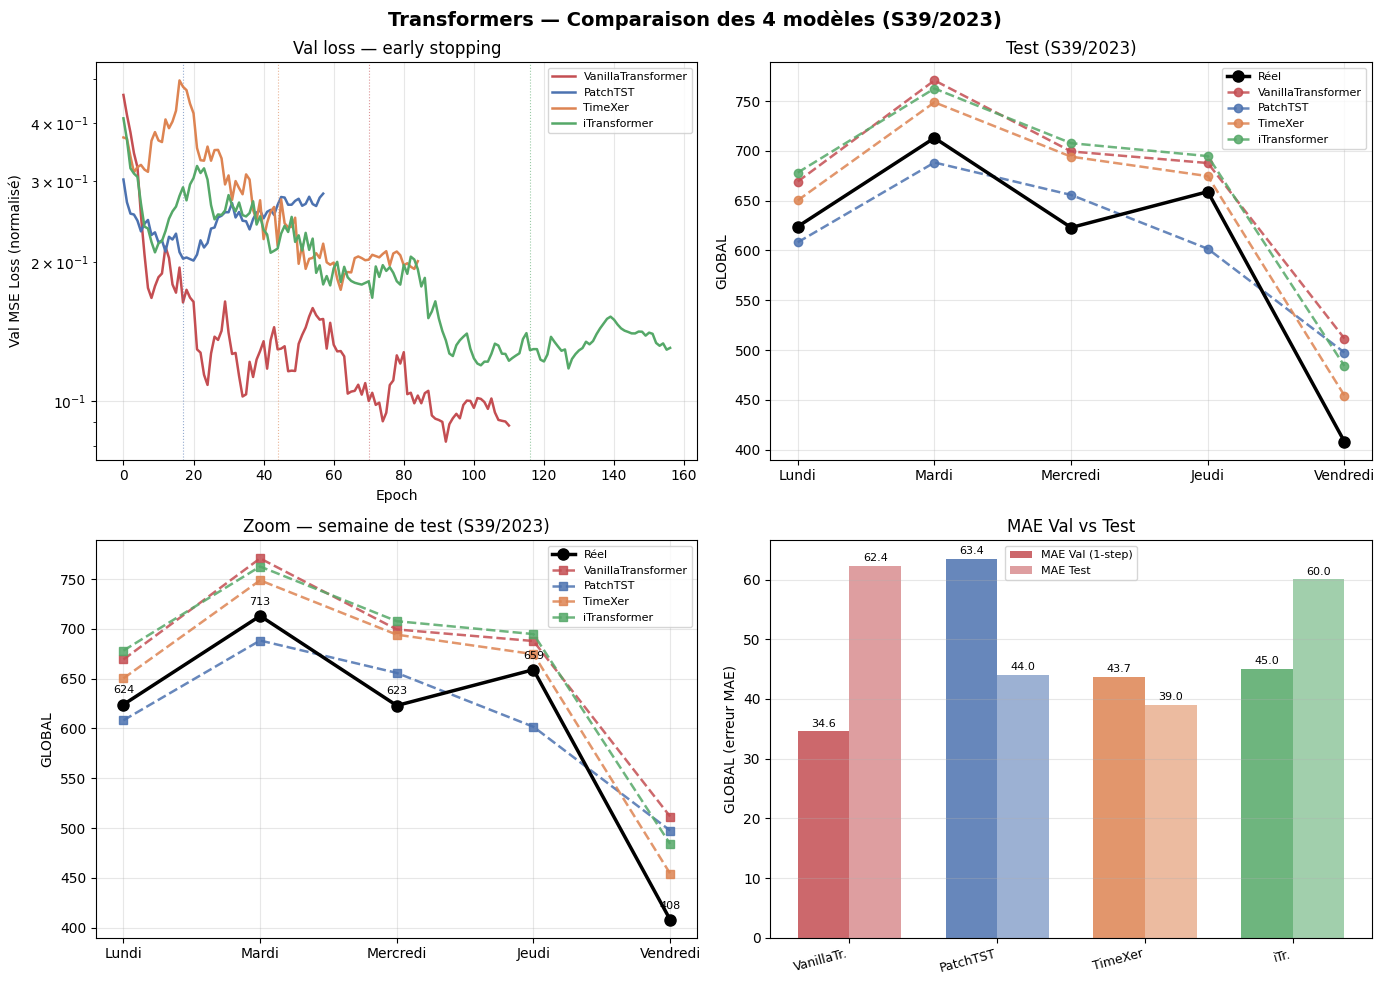

Figure sauvegardée → ../img/transformers_results.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Transformers — Comparaison des 4 modèles ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Courbes de val loss (early stopping) ─────────────────────────────
ax = axes[0, 0]
for name, hist in histories.items():
    smooth_val = pd.Series(hist['val']).rolling(5, min_periods=1).mean()
    ax.plot(smooth_val, lw=1.8, color=MODEL_COLORS[name], label=name)
    best_ep = int(np.argmin(hist['val']))
    ax.axvline(x=best_ep, color=MODEL_COLORS[name], ls=':', lw=0.8, alpha=0.6)
ax.set_xlabel('Epoch')
ax.set_ylabel('Val MSE Loss (normalisé)')
ax.set_title('Val loss — early stopping')
ax.legend(fontsize=8)
ax.set_yscale('log')
ax.grid(alpha=0.3)

# ── 2 : Prédictions vs Réel (Test) ───────────────────────────────────────
ax = axes[0, 1]
ax.plot(range(N_TEST), real_real, 'ko-', lw=2.5, ms=8, label='Réel', zorder=5)
for r in results:
    ax.plot(range(N_TEST), r['preds'], 'o--', lw=1.8, ms=6,
            color=MODEL_COLORS[r['model']], label=r['model'], alpha=0.85)
ax.set_xticks(range(N_TEST))
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Test ({TEST_LABEL})')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 3 : Zoom jour par jour avec annotations ───────────────────────────────
ax = axes[1, 0]
ax.plot(DAY_LABELS, real_real, 'ko-', lw=2.5, ms=8, label='Réel', zorder=5)
for r in results:
    ax.plot(DAY_LABELS, r['preds'], 's--', lw=1.8, ms=6,
            color=MODEL_COLORS[r['model']], label=r['model'], alpha=0.85)
for i, rv in enumerate(real_real):
    ax.annotate(f'{rv:.0f}', (i, rv), textcoords='offset points', xytext=(0, 8),
                ha='center', fontsize=8, color='black')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Zoom — semaine de test ({TEST_LABEL})')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# ── 4 : Barplot MAE Test & Val ────────────────────────────────────────────
ax = axes[1, 1]
names_short = [r['model'].replace('Transformer', 'Tr.') for r in results]
maes_test = [r['MAE']   for r in results]
maes_val  = [r['MAE_v'] for r in results]
x = np.arange(len(names_short))
w = 0.35
b1 = ax.bar(x - w/2, maes_val,  w, label='MAE Val (1-step)',  alpha=0.85,
            color=[MODEL_COLORS[r['model']] for r in results])
b2 = ax.bar(x + w/2, maes_test, w, label='MAE Test', alpha=0.55,
            color=[MODEL_COLORS[r['model']] for r in results])
ax.bar_label(b1, fmt='%.1f', fontsize=8, padding=2)
ax.bar_label(b2, fmt='%.1f', fontsize=8, padding=2)
ax.set_xticks(x)
ax.set_xticklabels(names_short, fontsize=9, rotation=15, ha='right')
ax.set_ylabel(f'{TARGET_COL} (erreur MAE)')
ax.set_title('MAE Val vs Test')
ax.legend(fontsize=8)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 11 — Tableau détaillé jour par jour

In [11]:
print(f'{"Jour":<10} {"Réel":>6}', end='')
for r in results:
    short = r['model'].replace('Transformer', 'Tr.')
    print(f'  {short:>16}', end='')
print()
print('-' * (16 + 6 + len(results) * 18))

for j, day in enumerate(DAY_LABELS):
    print(f'{day:<10} {real_real[j]:>6.0f}', end='')
    for r in results:
        pred = r['preds'][j]
        err  = pred - real_real[j]
        print(f'  {pred:>8.0f} ({err:>+5.0f})', end='')
    print()

print()
print(f'{"Modèle":<22} | {"MAE":>6}  {"MAPE":>7}  {"RMSE":>6}  {"R²":>7}')
print('-' * 52)
for r in sorted(results, key=lambda x: x['MAE']):
    print(f'{r["model"]:<22} | {r["MAE"]:>6.1f}  {r["MAPE"]:>6.1f}%  {r["RMSE"]:>6.1f}  {r["R2"]:>7.4f}')

Jour         Réel        VanillaTr.          PatchTST           TimeXer              iTr.
----------------------------------------------------------------------------------------------
Lundi         624       669 (  +45)       608 (  -16)       650 (  +26)       678 (  +54)
Mardi         713       771 (  +58)       688 (  -25)       749 (  +36)       763 (  +50)
Mercredi      623       699 (  +76)       656 (  +33)       694 (  +71)       708 (  +85)
Jeudi         659       688 (  +29)       602 (  -57)       675 (  +16)       695 (  +36)
Vendredi      408       512 ( +104)       497 (  +89)       454 (  +46)       484 (  +76)

Modèle                 |    MAE     MAPE    RMSE       R²
----------------------------------------------------
TimeXer                |   39.0     6.9%    43.4   0.8258
PatchTST               |   44.0     8.4%    51.4   0.7554
iTransformer           |   60.0    10.7%    62.7   0.6371
VanillaTransformer     |   62.4    11.5%    67.5   0.5788


In [12]:
import json, os

os.makedirs('../results', exist_ok=True)

save_list = []
for r in results:
    name = r['model']
    save_list.append({
        'model'        : name,
        'color'        : MODEL_COLORS[name],
        'val'          : {'MAE': float(r['MAE_v']), 'MAPE': float(r['MAPE_v']),
                          'RMSE': float(r['RMSE_v']), 'R2': float(r['R2_v'])},
        'test'         : {'MAE': float(r['MAE']),   'MAPE': float(r['MAPE']),
                          'RMSE': float(r['RMSE']),  'R2': float(r['R2'])},
        'preds'        : [float(x) for x in r['preds']],
        'real'         : [float(x) for x in real_real],
        'day_labels'   : DAY_LABELS,
        'test_label'   : TEST_LABEL,
        'loss_history' : {
            'train': [float(x) for x in histories[name]['train']],
            'val'  : [float(x) for x in histories[name]['val']],
        },
    })

out_path = '../results/transformers_results.json'
with open(out_path, 'w') as f:
    json.dump(save_list, f, indent=2)
print(f'Résultats sauvegardés → {out_path}  ({len(save_list)} modèles)')

Résultats sauvegardés → ../results/transformers_results.json  (4 modèles)
